<h1 style="text-align:center">Naïve-Bayes Classifier</h1>
<h2 style="text-align:center">Cifar10 & Fashion Mnist datasets</h2>

<div class="alert alert-success">
*Hugo Barbaroux*
<br>
Python Version: **3.6.5**
<br>
Jupyter Version: **5.5.0**
</div>

In [2]:
# Computational imports
from PIL import Image
import scipy.io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, log_loss
import pandas as pd

# Use of the seaborn style for graphics
import seaborn as sb
sb.set()

import time

# Introduction

## Import of the datasets

In [4]:
from keras.datasets import cifar10, fashion_mnist

In [5]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = fashion_mnist.load_data()

In [6]:
cifar_labels=["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
mnist_labels=["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

## Observations about the distribution of class labels and the dimensionality of the input.

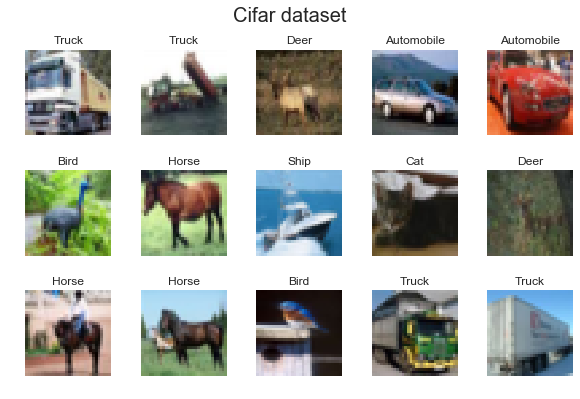

In [7]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.4) 

plt.suptitle("Cifar dataset", fontsize=20)
for i in range(1, 16):
    ax = fig.add_subplot(3, 5, i)
    ax.imshow(x_train_cifar10[i])
    ax.set_title(cifar_labels[y_train_cifar10[i,0]])
    ax.axis('off')
    ax.grid()

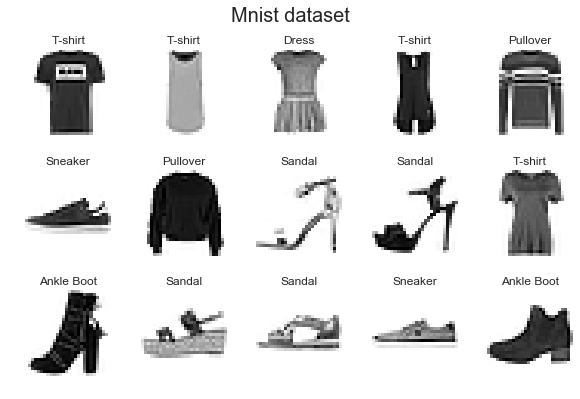

In [8]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.4) 

plt.suptitle("Mnist dataset", fontsize=20)
for i in range(1, 16):
    ax = fig.add_subplot(3, 5, i)
    ax.imshow(x_train_mnist[i], cmap="binary")
    ax.set_title(mnist_labels[y_train_mnist[i]])
    ax.axis('off')
    ax.grid()

In [9]:
print("Shape of cifar training set : {}".format(x_train_cifar10.shape))
print("Shape of cifar testing set : {}".format(x_test_cifar10.shape))
print("Shape of mnist training set : {}".format(x_train_mnist.shape))
print("Shape of mnist testing set : {}".format(x_test_mnist.shape))

Shape of cifar training set : (50000, 32, 32, 3)
Shape of cifar testing set : (10000, 32, 32, 3)
Shape of mnist training set : (60000, 28, 28)
Shape of mnist testing set : (10000, 28, 28)


Both datasets contain images, 50000-60000 in the train set and 10000 in the test set. One of the differences is the size of the images, 32x32 for the cifar set while 28x28 for the mnist one. However, the main difference is that cifar set images are color ones while those of the mnist set are black-and-white ones.

The last point can affect a lot the training of the cifar set. The computation time will increase, as much as the convergence speed, because of the higher dimension of the dataset. Moreover, the cifar images are noticeably harder to classify ; from a human eye, it can took few seconds, depending on the image, to be able to detect its class, while we can detect it immediately for a fashion mnist image.

For both datasets, the class labels are integers between 0 and 9, that match with real things. For example, images of the cifar set can be airplanes, frogs, trucks among others, while those of the mnist set are clothes. This point might make the training of the mnist set more complicated. Indeed, a frog and an airplane should be more easily distinguishable than a shirt and a handbag, both black-and-white images. 

All the labels are equally present in all sets, which means prior densities will be uniform ones.

# Classification

## Implementation of the Naïve-Bayes Classifier

In a Bayes Classifier, in order to classify a new item $\mathbf{x_\text{new}}$, we compute the probabilities of this item to belong to a certain class $k$. In order to do this, we use the following formula:
$$
P\left(t_\text{new}=k\left|\mathbf{X},\mathbf{t},\mathbf{x_\text{new}}\right.\right)=\frac{p\left(\mathbf{x_\text{new}}\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)P\left(t_\text{new}=k\right)}{\sum_j\left[p\left(\mathbf{x_\text{new}}\left|\mathbf{X},\mathbf{t},t_\text{new}=j\right.\right)P\left(t_\text{new}=j\right)\right]}.
$$
If we use in addition the Naïve-Bayes assumption, that considers all components of $\mathbf{x_\text{new}}$as independent, the preivous formula would be
$$
P\left(t_\text{new}=k\left|\mathbf{X},\mathbf{t},\mathbf{x_\text{new}}\right.\right)=\frac{P\left(t_\text{new}=k\right)\prod\limits_{d=1}^D p\left(\mathbf{x_\text{new}}^d\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)}{\sum_j\left[p\left(\mathbf{x_\text{new}}\left|\mathbf{X},\mathbf{t},t_\text{new}=j\right.\right)P\left(t_\text{new}=j\right)\right]}.
$$
    To avoid computing the marginal likelihood (denominator of the previous formula), as we just want a prediction, not particularly all the probabilities, we can only compute the product from the Naïve-Bayes assumption. Actually, we should not try to compute the normalization factor here. Indeed, due to a high divergence, the sum could end up to be infinite and flatten all the probabilities to 0.

Thus, we just need to find
$$
\underset{k}{\text{argmax}}\left[P\left(t_\text{new}=k\right)\prod\limits_{d=1}^D p\left(\mathbf{x_\text{new}}^d\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)\right]
$$

Here, as labels are equally distributed in our datasets, a good **prior** we can choose is a **uniform one**. Then, the previous formula will be:
$$
\underset{k}{\text{argmax}}\left[\prod\limits_{d=1}^D p\left(\mathbf{x_\text{new}}^d\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)\right]
$$

Finally, as the element we are studying here are really different from each other, computations of $p\left(\mathbf{x_\text{new}}^d\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)$ generally give 0 as a result. To avoid this **underflow**, we can compute the log-densities :
$$
\underset{k}{\text{argmax}}\left[\exp\sum\limits_{d=1}^D \log \left[p\left(\mathbf{x_\text{new}}^d\left|\mathbf{X},\mathbf{t},t_\text{new}=k\right.\right)\right]\right]
$$

<div class="alert alert-warning">
Useful functions
</div>

In [10]:
def init_list_dict(length) :
    ''' Creates a dict of void lists '''
    new_dict = {}
    for i in range(length) :
        new_dict[i] = []
        
    return new_dict


def sort_data_by_class(dataset, labels, nbr_classes) :
    ''' Given a dataset and corresponding labels, returns a dictionary (class, [samples of this class]) '''
    classed_data = init_list_dict(nbr_classes)
    
    for i in range(len(dataset)) :
        classed_data[labels[i]].append(dataset[i])
        
    return classed_data

In [11]:
def log_gaussian_distri(x, mean, sigma_sqr) :
    ''' Computation of the log value of a gaussian distribution (can be independently mutlivariate)'''
    return ((-1/2)*(np.square(x-mean))/sigma_sqr)-np.log(np.sqrt(2*np.pi*sigma_sqr))


def extended_mean(classed_data, nbr_classes) :
    ''' classed_data : dictionnary (class, [samples of this class])  
        Returns a dictionnary (class, element-wise mean of the samples of this class) '''
    mean_dict = init_list_dict(nbr_classes)
    for k in range(nbr_classes) :
        mean_dict[k] = np.average(classed_data[k], axis=0)
        
    return mean_dict


def extended_sigma_square(classed_data, nbr_classes, mean_dict) :
    ''' classed_data : dictionnary (class, [samples of this class])
        mean_dict : dictionnary (class, element-wise mean of the samples of this class)
        Returns a dictionnary (class, element-wise variance of the samples of this class) '''
    sigma_sqr_dict = init_list_dict(nbr_classes)
    for k in range(nbr_classes) :
        data = classed_data[k]
        Nk = len(data)
        sigma_sqr_dict[k] = (np.average(np.square(data-mean_dict[k]), axis=0)*Nk/(Nk-1))+10**(-9)
        
    return sigma_sqr_dict

<div class="alert alert-warning">
Implementation of the Naïve-Bayes Classifier
</div>

In [12]:
def NB_Parameters(train_dataset, labels, nbr_classes) :
    ''' Given a dataset, returns 3 dictionnary, each indexed with the classes:
        - data by class
        - element-wise data mean, by class 
        - element-wisedata variance, by class'''
    classed_data_train = sort_data_by_class(train_dataset, labels, nbr_classes)
    mean_dict = extended_mean(classed_data_train, nbr_classes)
    return classed_data_train, mean_dict, extended_sigma_square(classed_data_train, nbr_classes, mean_dict)


def NB_Classifier(x_new, mean_dict, sigma_sqr_dict, nbr_classes) :
    ''' Given element-wise mean and variance for each class, 
        returns the most likely class to which a new sample should be attributed '''
    P = []
    for k in range(nbr_classes) :
        P.append(np.exp(np.sum(log_gaussian_distri(x_new, mean_dict[k], sigma_sqr_dict[k]))))
    
    return np.argmax(P)


def NB_predict_labels(test_data, mean_dict, sigma_sqr_dict, nbr_classes) :
    ''' Extentsion of the previous function to a list of samples '''
    predicted_labels = []
    for i in range(len(test_data)) :
        predicted_labels.append(NB_Classifier(test_data[i], mean_dict, sigma_sqr_dict, nbr_classes))
        
    return np.array(predicted_labels)

In [13]:
def get_accuracy(predicted_labels, true_labels) :
    n = len(true_labels)
    positives = 0
    for i in range(n) :
        positives += 1 if (predicted_labels[i] == true_labels[i]) else 0
        
    return positives/n

In [14]:
def get_log_lik(predicted_labels, true_labels) :
    return true_labels*np.log(predicted_labels) + (1-true_labels)*np.log(1-predicted_labels)

## Naïve-Bayes classifier features

Generally, the most positive feature of the Bayes classifier is the positibility to get probabilities for a sample to belong to a certain class, instead of a simple prediction. However, the problem in the computation of the strict probabilities makes this argument a bit less true here. Because of the high diversity in these probabilities, the normalization is quite impossible, and probabilities are not so meaningful that in general applications of the Bayes classifier.

Even if we could say that the simplicity of the Naïve bayes classifier is one of its most important characteristics, it is actually the cause of negative points. In particular, the Naïve assumption the really weighty, and stating that all components of the samples are independent is quite restrictive. Indeed, we are dealing with pixels, composing pictures, and a given real pixel is correlated in some ways with its neighbors.

## Data pre-processing

As pixel values are between 0 and 255, computation can result in large numbers, quite painful to work with, especially because they can overflow. Thus we can **rescale the samples between 0 and 1** to avoid such problems.

When computing variance on pixels, it turns out that some of them are null - for example, pixels at boundaries of fashion mnist images are always white. In order to be able to compute values from all densities, we can add a small value to the variances, for example $10^{-9}$.

## Application of the Naïve-Bayes Classifier to the two datasets.

In [15]:
# Rescaling
x_train_cifar10_norm, x_test_cifar10_norm, x_train_mnist_norm, x_test_mnist_norm = np.divide(x_train_cifar10,255), np.divide(x_test_cifar10,255), np.divide(x_train_mnist,255), np.divide(x_test_mnist,255)

# Formating the labels of the Cifar train dataset from (50000,1) to (50000,)
y_train_cifar10_reshape = y_train_cifar10.reshape(-1)

<div class="alert alert-warning">
Cifar Dataset
</div>

In [16]:
# Computation of the model parameters for the Cifar dataset
classed_data_cifar, mean_dict_cifar, sigma_sqr_dict_cifar = NB_Parameters(x_train_cifar10_norm, y_train_cifar10_reshape, 10)

In [17]:
# Label predictions of the Cifar test samples
predicted_labels_cifar_test = NB_predict_labels(x_test_cifar10_norm, mean_dict_cifar, sigma_sqr_dict_cifar, 10)

In [18]:
# Computation of the accuracy of these predictions
accuracy_cifar_test = get_accuracy(predicted_labels_cifar_test,y_test_cifar10)
print("Predictions accuracy on the Cifar10 test samples: {}".format(accuracy_cifar_test))

Predictions accuracy on the Cifar10 test samples: 0.2527


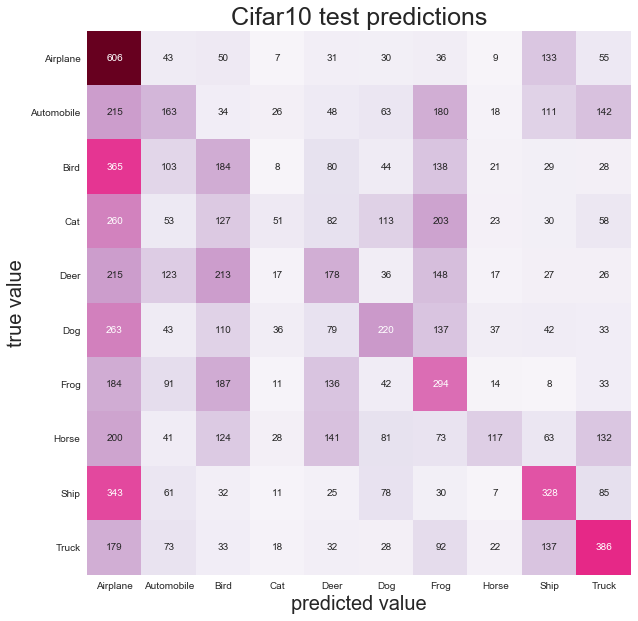

In [19]:
plt.figure(figsize=(15,10))

mat = confusion_matrix(y_test_cifar10, predicted_labels_cifar_test)
sb.heatmap(mat, square=True, annot=True, cbar=False, fmt='g', cmap='PuRd', xticklabels=cifar_labels, yticklabels=cifar_labels)

plt.title("Cifar10 test predictions", fontsize="25")
plt.xlabel('predicted value', fontsize="20")
plt.ylabel('true value', fontsize="20")
plt.yticks(rotation=0);

<div class="alert alert-warning">
Mnist Dataset
</div>

In [20]:
# Computation of the model parameters for the Mnist dataset
classed_data_mnist, mean_dict_mnist, sigma_sqr_dict_mnist = NB_Parameters(x_train_mnist_norm, y_train_mnist, 10)

In [21]:
# Label predictions of the Mnist test samples
predicted_labels_mnist_test = NB_predict_labels(x_test_mnist_norm, mean_dict_mnist, sigma_sqr_dict_mnist, 10)

In [22]:
# Computation of the accuracy of these predictions
accuracy_mnist_test = get_accuracy(predicted_labels_mnist_test,y_test_mnist)
print("Predictions accuracy on the Fashion Mnist test dataset: {}".format(accuracy_mnist_test))

Predictions accuracy on the Fashion Mnist test dataset: 0.5264


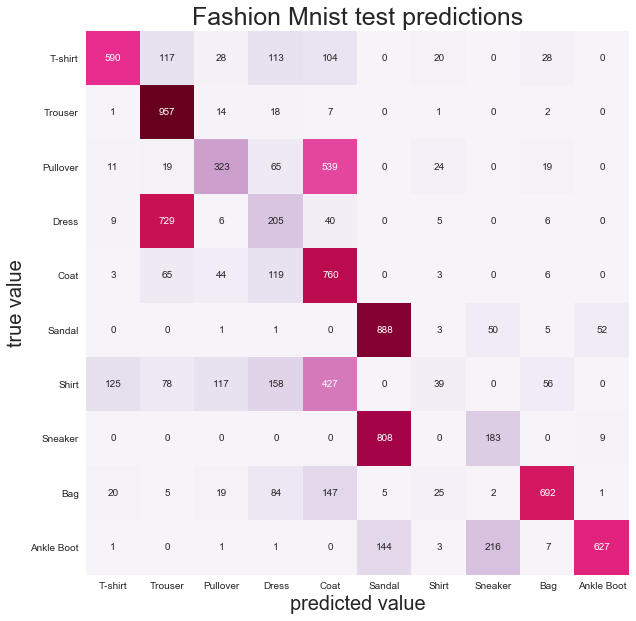

In [23]:
plt.figure(figsize=(15,10))

mat = confusion_matrix(y_test_mnist, predicted_labels_mnist_test)
sb.heatmap(mat, square=True, annot=True, cbar=False, fmt='g', cmap='PuRd', xticklabels=mnist_labels, yticklabels=mnist_labels)

plt.title("Fashion Mnist test predictions", fontsize="25")
plt.xlabel('predicted value', fontsize="20")
plt.ylabel('true value', fontsize="20")
plt.yticks(rotation=0);

## Performance and improvements.

In [24]:
print("Accuracy of a random classifier : {}".format(get_accuracy(np.random.randint(0,10,(10000,1)), y_test_cifar10)))

Accuracy of a random classifier : 0.096


With what we have seen so far, the accuracy of the Naïve Bayes classifier is respectively 0.25 and 0.52 for the Cifar dataset and the Fashion Mnist one. In themselves, such accuracies are not so good ; predicting approximately no more than 50% righly is not something that can be really used.

However, with 10 possible classes, a random classifier gives an accuracy of 10%. Thus, with the two given datasets, the Naïve Bayes classifier is between 2.5 to 5 times more accurate than a random classifier, which is already a positive result.

**Improvements**

We can see that the Cifar classification is harder than the Fashion Mnist one. This is partly due to colors. To improve the performance, we can try to preprocess the Cifar data by making the images as black-and-white ones. However, as Cifar images are quite complicated ones, maybe we should take this idea further by working with binary pixels, with a value of 0 or 1. Thanks to that, the classifier could focus on shapes rather than losing itself with background details and so on.

Another way of improvement would be to add a correlation factor between pixels, as they are actually not independent. This can be done by using mutlivariate gaussians with non diagonal covariance matrixes, but it can be a lot harder to work with. Another way of playing with these dependencies is to change the dimensional space before applaying the classifier, in order to work with image variations rather than intensities.

# Regression

## Implementation of the Bayesian Linear Regression

In Bayesian Linear Regression, we compute a distribution of models fitting the training data, using the Bayes rule:
$$
p\left(\mathbf{w}|\mathbf{X},\mathbf{t},\sigma^2\right)=\frac{p\left(\mathbf{t}|\mathbf{X},\mathbf{w},\sigma^2\right)p\left(\mathbf{w}\right)}{p\left(\mathbf{t}|\mathbf{X},\sigma^2\right)},
$$
where $\mathbf{t}$ are the training true labels and, if the training set is made up of the samples $x_1,\dots,x_N$:
$$
\mathbf{X}=
\begin{pmatrix}
  1 & x_1 & x_1^2 & \dots & x_1^D \\
  1 & x_2 & x_2^2 & \dots & x_2^D \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  1 & x_N & x_N^2 & \dots & x_N^D \\
\end{pmatrix}
$$

Here, samples are arrays of pixels, $\mathbf{x_i}=[p_1,\dots,p_M]$. As $\mathbf{X}$ must be a 2D matrix, we will extend the previous definition of $\mathbf{X}$ with $\mathbf{x_i}^k=[p_1^k,\dots,p_M^k]$.

If we set the prior $p\left(\mathbf{w}\right)$ as a gaussian one, for example $p\left(\mathbf{w}\right)=\mathcal{N}(0,\mathbf{S})$, with $\mathbf{S}$ arbitrary (the effect of the prior will decrease as the training dataset is larger, so the initialization of $\mathbf{S}$ is not really a concern), then thanks to conjugacy assumptions:
$$
p\left(\mathbf{w}|\mathbf{X},\mathbf{t},\sigma^2\right)=\mathcal{N}\left(\mathbf{\mu},\mathbf{\Sigma}\right),
$$
where $\mathbf{\Sigma}=\left(\frac{1}{\sigma^2}\mathbf{X}^\mathsf{T}\mathbf{X}+\mathbf{S}^{-1}\right)^{-1}$ and $\mathbf{\mu}=\frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^\mathsf{T}\mathbf{t}$.

Then, after some expectation computations, the distribution of the prediction of a sample $\mathbf{x_\text{new}}$ is
$$
p\left(\mathbf{t_\text{new}}|\mathbf{X},\mathbf{t},\mathbf{x_\text{new}},\sigma^2\right)=\mathcal{N}\left(\mathbf{x_\text{new}}^\mathsf{T}\mathbf{\mu},\sigma^2+\mathbf{x_\text{new}}^\mathsf{T}\mathbf{\Sigma}\mathbf{x_\text{new}}\right)
$$

In order to compute a prediction, we can select the mode of the previous distribution, which means
$$
\mathbf{t_\text{new}}=\mathbf{x_\text{new}}^\mathsf{T}\mathbf{\mu}
$$

<div class="alert alert-warning">
Useful functions
</div>

In [25]:
def get_X(x, n):
    ''' Given a set of samples and an order,
        returns the X matrix by the previous formula '''
    return np.array([np.array([a**i for i in range(n+1)]).flatten() for a in x])

To get $\sigma^2$, we should use the formula
$$
\widehat{\sigma^2}=\frac{1}{||\mathbf{t}||-1}\left(\mathbf{t}-\mathbf{X}\hat{\mathbf{w}}\right)^\mathsf{T}\left(\mathbf{t}-\mathbf{X}\hat{\mathbf{w}}\right),
$$
where
$$
\hat{\mathbf{w}}=\left(\mathbf{X}^\mathsf{T}\mathbf{X}\right)^{-1}\mathbf{X}^\mathsf{T}\mathbf{t}
$$

In [26]:
def get_w_hat(X, y) :
    X_t = np.transpose(X)
    return (np.linalg.inv(X_t.dot(X)+0.001*np.random.randn(X.shape[1],X.shape[1])).dot(X_t)).dot(y)


def get_sigma2_hat(X, w_hat, t):
    temp = np.transpose(t)-X.dot(w_hat)
    return ((1/(len(t)-1))*np.transpose(temp).dot(temp))


def get_S(X) :
    return np.diag(np.array([10 for _ in range(X.shape[1])]))


def get_Sigma_mu(X, S, sigma2_hat, t):
    X_t = np.transpose(X)
    Sigma = np.linalg.inv((1/sigma2_hat)*X_t.dot(X)+np.linalg.inv(S))
    mu = (1/sigma2_hat)*(Sigma.dot(X_t)).dot(t)
    return Sigma, mu

<div class="alert alert-warning">
Implementation of the Bayesian Linear Regression
</div>

In [27]:
def BLR(x_new, mu) :
    ''' Given a new sample and mu as in the previous formulae,
        returns a regression prediction '''
    return np.transpose(x_new).dot(mu)

In [31]:
def BLR_predict_labels(test_data, mu) :
    ''' Extension of the preivous function to a set of new samples '''
    predicted_labels = []
    for i in range(len(test_data)) :
        predicted_labels.append(BLR(test_data[i], mu))
        
    return np.array(predicted_labels)

In [32]:
def BLR_many_orders(max_order, test_data, train_data, train_labels) :
    ''' Compute multiple order regressions '''
    predictions = []
    for i in range(1, max_order+1) :
        t1 = time.time()
        X_test = get_X(test_data,i)
        X_train = get_X(train_data,i)
        mu = get_Sigma_mu(X_train, 
                          get_S(X_train), 
                          get_sigma2_hat(X_train, get_w_hat(X_train, train_labels), train_labels),
                          train_labels)[1]
        predictions += [BLR_predict_labels(X_test, mu)]
        print("Computation time for order {} : {}".format(i,time.time()-t1))
    
    return predictions

## Application to the given datasets

<div class="alert alert-warning">
Cifar dataset
</div>

In [33]:
predictions_cifar = BLR_many_orders(1, x_test_cifar10_norm, x_train_cifar10_norm, y_train_cifar10_reshape)

Computation time for order 1 : 636.6952791213989


<div class="alert alert-warning">
Mnist dataset
</div>

In [37]:
predictions_mnist = BLR_many_orders(4, x_test_mnist_norm, x_train_mnist_norm, y_train_mnist)

Computation time for order 1 : 43.388331174850464
Computation time for order 2 : 75.24324297904968
Computation time for order 3 : 122.43473505973816
Computation time for order 4 : 199.2562062740326


## Results and errors

In [38]:
def mean_squared_error(x,y) :
    return (1/len(x))*np.sum((x-y)**2)

Cifar test mean quared error - Order 1: 7.83153056015645


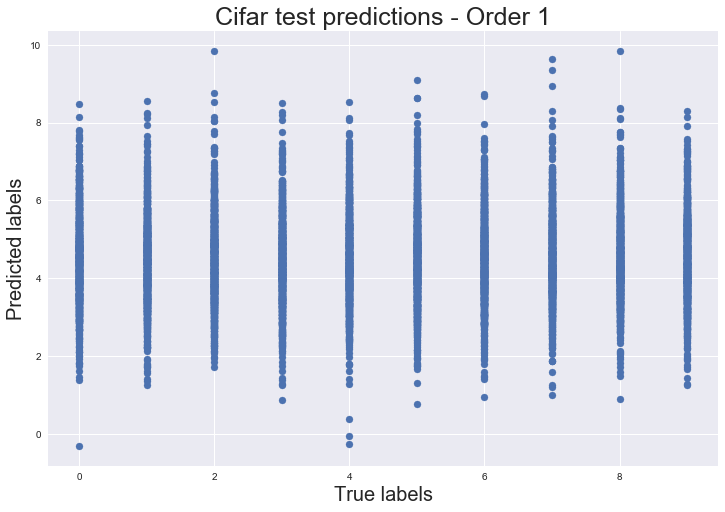

In [36]:
print("Cifar test mean quared error - Order {}: {}".format(1,mean_squared_error(predictions_cifar[0],y_test_cifar10.reshape(-1))))

fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

ax.scatter(y_test_mnist, predictions_cifar[0])

ax.set_title("Cifar test predictions - Order 1", fontsize=25)
ax.set_xlabel("True labels", fontsize=20)
ax.set_ylabel("Predicted labels", fontsize=20);

Cifar test mean quared error - Order 1: 1.9656604400009974
Cifar test mean quared error - Order 2: 1.7575304391664708
Cifar test mean quared error - Order 3: 1.726368169864057
Cifar test mean quared error - Order 4: 1.7109527356249463


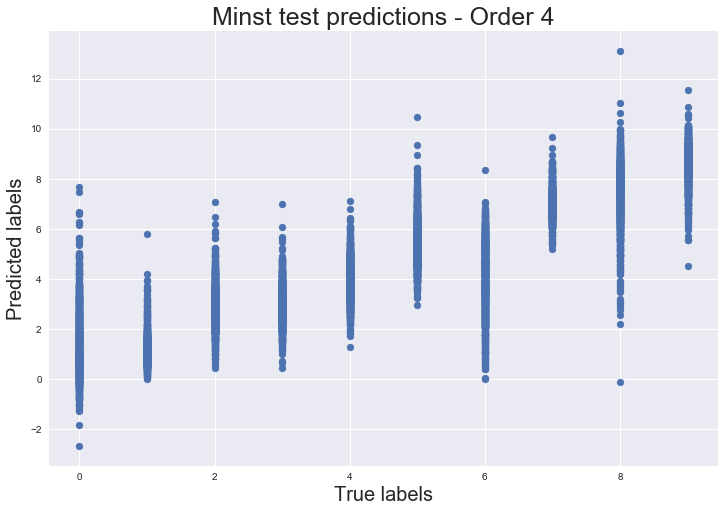

In [39]:
for i in range(4) :
    print("Cifar test mean squared error - Order {}: {}".format(i+1,mean_squared_error(predictions_mnist[i],y_test_mnist)))

fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

ax.scatter(y_test_mnist, predictions_mnist[3])

ax.set_title("Minst test predictions - Order 4", fontsize=25)
ax.set_xlabel("True labels", fontsize=20)
ax.set_ylabel("Predicted labels", fontsize=20);

## Discretizing predictions, confusion matrixes and accuracies.

We can see that the range of continuous predictions, for both datasets, is approximately $[-2.5, 12.5]$. The easiest way to discretize these predictions is to round them. For those outside the range $[0,9]$, they are brought back to the boundaries (predictions < 0 become 0 and predictions > 9 become 9).

We test here two ways of discritizing: using the `int()` casting or the `round()` function.

In [42]:
def discretize_int(predictions) :
    return [0 if x < 0 else 9 if x > 9 else int(x) for x in predictions]

def discretize_round(predictions) :
    return [0 if x < 0 else 9 if x > 9 else round(x) for x in predictions]

Discretizing using int() casting :
	Cifar test accuracy - Order 1: 0.1078

Discretizing using round() function :
	Cifar test accuracy - Order 1: 0.1138


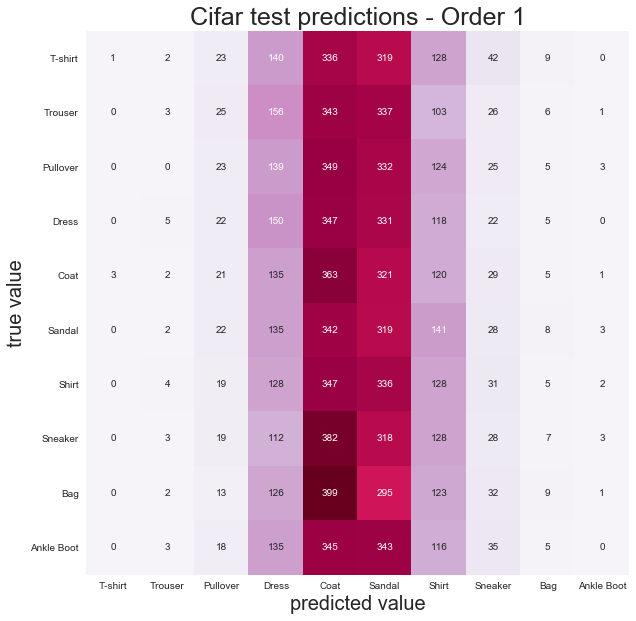

In [43]:
print("Discretizing using int() casting :")
for i in range(len(predictions_cifar)) :
    print("\tCifar test accuracy - Order {}: {}".format(i+1,get_accuracy(discretize_int(predictions_cifar[i]),y_test_cifar10)))

print("\nDiscretizing using round() function :")
for i in range(len(predictions_cifar)) :
    print("\tCifar test accuracy - Order {}: {}".format(i+1,get_accuracy(discretize_round(predictions_cifar[i]),y_test_cifar10)))

plt.figure(figsize=(15,10))

mat = confusion_matrix(y_test_mnist, discretize_round(predictions_cifar[0]))
sb.heatmap(mat, square=True, annot=True, cbar=False, fmt='g', cmap='PuRd', xticklabels=mnist_labels, yticklabels=mnist_labels)

plt.title("Cifar test predictions - Order 1", fontsize="25")
plt.xlabel('predicted value', fontsize="20")
plt.ylabel('true value', fontsize="20")
plt.yticks(rotation=0);

Discretizing using int() casting :
	Mnist test accuracy - Order 1: 0.3328
	Mnist test accuracy - Order 2: 0.356
	Mnist test accuracy - Order 3: 0.3602
	Mnist test accuracy - Order 4: 0.3624

Discretizing using round() function :
	Mnist test accuracy - Order 1: 0.3856
	Mnist test accuracy - Order 2: 0.4402
	Mnist test accuracy - Order 3: 0.4463
	Mnist test accuracy - Order 4: 0.4489


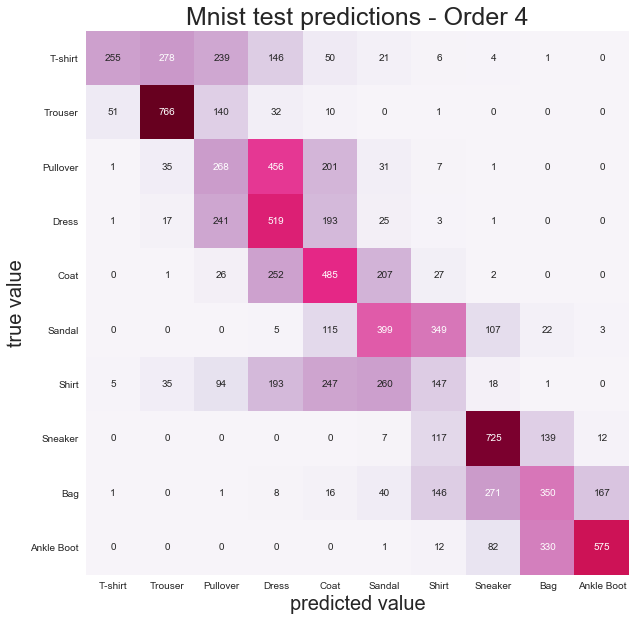

In [44]:
print("Discretizing using int() casting :")
for i in range(len(predictions_mnist)) :
    print("\tMnist test accuracy - Order {}: {}".format(i+1,get_accuracy(discretize_int(predictions_mnist[i]),y_test_mnist)))

print("\nDiscretizing using round() function :")
for i in range(len(predictions_mnist)) :
    print("\tMnist test accuracy - Order {}: {}".format(i+1,get_accuracy(discretize_round(predictions_mnist[i]),y_test_mnist)))

plt.figure(figsize=(15,10))

mat = confusion_matrix(y_test_mnist, discretize_round(predictions_mnist[3]))
sb.heatmap(mat, square=True, annot=True, cbar=False, fmt='g', cmap='PuRd', xticklabels=mnist_labels, yticklabels=mnist_labels)

plt.title("Mnist test predictions - Order 4", fontsize="25")
plt.xlabel('predicted value', fontsize="20")
plt.ylabel('true value', fontsize="20")
plt.yticks(rotation=0);

## Regression performance with respect to the classification one.

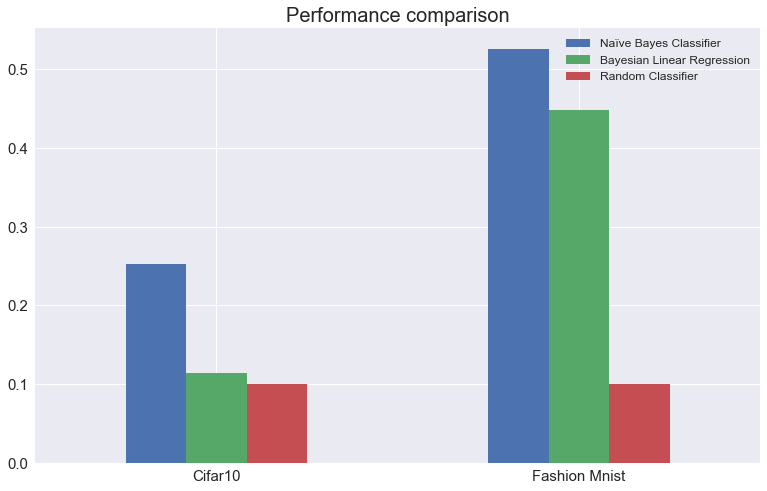

In [45]:
df = pd.DataFrame(np.array([[accuracy_cifar_test,get_accuracy(discretize_round(predictions_cifar[0]),y_test_cifar10),0.10],[accuracy_mnist_test,get_accuracy(discretize_round(predictions_mnist[3]),y_test_mnist),0.10]]), index=['Cifar10', 'Fashion Mnist'], columns=['Naïve Bayes Classifier', 'Bayesian Linear Regression', 'Random Classifier'])
fig = df.plot.bar(rot='0', figsize=(13,8), fontsize='15')
fig.set_title("Performance comparison", fontsize="20")
fig.legend(fontsize="12");

We can see that Bayesian Linear Regression is pretty bad with respect to Naïve-Bayes Classification, even not really better than a random classifier for the Cifar dataset.

Actually, this is due to the kind of samples we are trying to classify. Using regression suggests we are trying to build a linear relationship between samples. However, with images, and particularly those we are working with, it is very difficult. In addition to the poor quality of the samples, labels that are used cannot easily lead to some clean linear relationship. For the Cifar dataset for example, labels 2 and 9 (respectively *Automobile* and *Truck*) are close to each other, while they are really different from labels in between, for example labels 3 and 7 (*Bird* and *Frog*). 

Admittedly, such a regression is not so bad for the Fashion Mnist dataset. There is a difference due to the point stated just before, but smaller than for the Cifar dataset. Actually, in additoon with samples from a same class more similar to each other, labels are better distributed. For example, *Sneaker* and *Sandal* are to close labels and correspond to products that look alike. This is the same thing for *Pullover*, *Dress* and *Coat*. This feature makes the regression more sensible and so more reliable.